In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
# https://www.kaggle.com/rikdifos/credit-card-approval-prediction

In [3]:
import joblib
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

In [4]:
random.seed(0)
np.random.seed(0)

In [5]:
application_df = pd.read_csv("../Data/application_record.csv")
application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [6]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
application_df.drop_duplicates('ID', keep='last', inplace=True)

In [8]:
len(application_df)

438510

In [9]:
application_df.describe(percentiles=np.arange(.1, 1, .1)).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
ID,438510.0,6.022035e+06,571496.239776,5008804.0,5181098.9,5454300.8,5726384.7,5890306.6,6047719.5,6162346.4,6351351.3,6543744.6,6722537.1,7999952.0
CNT_CHILDREN,438510.0,4.273928e-01,0.724887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,19.0
AMT_INCOME_TOTAL,438510.0,1.875209e+05,110080.727479,26100.0,90000.0,112500.0,135000.0,148500.0,161100.0,180000.0,211500.0,247500.0,315000.0,6750000.0
DAYS_BIRTH,438510.0,-1.599782e+04,4185.058074,-25201.0,-21982.0,-20288.0,-18678.0,-17044.0,-15630.0,-14401.0,-13166.0,-11844.0,-10519.0,-7489.0
DAYS_EMPLOYED,438510.0,6.056202e+04,138766.410761,-17531.0,-5295.0,-3588.0,-2723.0,-2020.0,-1468.0,-1002.0,-573.0,-187.0,365243.0,365243.0
FLAG_MOBIL,438510.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,438510.0,2.061344e-01,0.404529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
FLAG_PHONE,438510.0,2.877631e-01,0.452721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
FLAG_EMAIL,438510.0,1.082028e-01,0.310637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
CNT_FAM_MEMBERS,438510.0,2.194463e+00,0.897210,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,20.0


In [10]:
# we will be storing years here
application_df['DAYS_BIRTH'] = -1*application_df['DAYS_BIRTH']/365
application_df['DAYS_EMPLOYED'] = application_df['DAYS_EMPLOYED'].apply(lambda x : -1*x/365 if x < 0 else 0)

In [11]:
application_df.describe(percentiles=np.arange(.1, 1, .1)).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
ID,438510.0,6.022035e+06,571496.239776,5.008804e+06,5.181099e+06,5.454301e+06,5.726385e+06,5.890307e+06,6.047720e+06,6.162346e+06,6.351351e+06,6.543745e+06,6.722537e+06,7.999952e+06
CNT_CHILDREN,438510.0,4.273928e-01,0.724887,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.900000e+01
AMT_INCOME_TOTAL,438510.0,1.875209e+05,110080.727479,2.610000e+04,9.000000e+04,1.125000e+05,1.350000e+05,1.485000e+05,1.611000e+05,1.800000e+05,2.115000e+05,2.475000e+05,3.150000e+05,6.750000e+06
DAYS_BIRTH,438510.0,4.382963e+01,11.465913,2.051781e+01,2.881918e+01,3.244932e+01,3.607123e+01,3.945479e+01,4.282192e+01,4.669589e+01,5.117260e+01,5.558356e+01,6.022466e+01,6.904384e+01
DAYS_EMPLOYED,438510.0,5.952197e+00,6.568309,0.000000e+00,0.000000e+00,5.123288e-01,1.569863e+00,2.745205e+00,4.021918e+00,5.534247e+00,7.460274e+00,9.830137e+00,1.450685e+01,4.803014e+01
FLAG_MOBIL,438510.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
FLAG_WORK_PHONE,438510.0,2.061344e-01,0.404529,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
FLAG_PHONE,438510.0,2.877631e-01,0.452721,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
FLAG_EMAIL,438510.0,1.082028e-01,0.310637,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
CNT_FAM_MEMBERS,438510.0,2.194463e+00,0.897210,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,2.000000e+01


In [12]:
numeric_columns = application_df.select_dtypes(include=['number']).columns
len(numeric_columns)

10

In [13]:
for c in application_df.select_dtypes(include=['object']).columns:
    print(application_df[c].value_counts(dropna=False))
    print("*"*20)

F    294412
M    144098
Name: CODE_GENDER, dtype: int64
********************
N    275428
Y    163082
Name: FLAG_OWN_CAR, dtype: int64
********************
Y    304043
N    134467
Name: FLAG_OWN_REALTY, dtype: int64
********************
Working                 226087
Commercial associate    100739
Pensioner                75483
State servant            36184
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64
********************
Secondary / secondary special    301789
Higher education                 117509
Incomplete higher                 14849
Lower secondary                    4051
Academic degree                     312
Name: NAME_EDUCATION_TYPE, dtype: int64
********************
Married                 299798
Single / not married     55268
Civil marriage           36524
Separated                27249
Widow                    19671
Name: NAME_FAMILY_STATUS, dtype: int64
********************
House / apartment      393788
With parents            19074
Municipal apart

In [14]:
application_df['OCCUPATION_TYPE'].fillna("NA", inplace=True)

In [15]:
le = LabelEncoder()
for c in application_df.select_dtypes(include=['object']).columns:
    application_df[c] = le.fit_transform(application_df[c])

In [16]:
application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,32.890411,12.443836,1,1,0,0,12,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,32.890411,12.443836,1,1,0,0,12,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,58.832877,3.106849,1,0,0,0,17,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,52.356164,8.358904,1,0,1,1,15,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,52.356164,8.358904,1,0,1,1,15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,1,0,1,0,135000.0,1,4,2,1,62.238356,0.000000,1,0,0,0,12,1.0
438553,6840222,0,0,0,0,103500.0,4,4,3,1,43.668493,8.238356,1,0,0,0,8,1.0
438554,6841878,0,0,0,0,54000.0,0,1,3,5,22.380822,1.019178,1,1,0,0,15,1.0
438555,6842765,0,0,1,0,72000.0,1,4,1,1,59.378082,0.000000,1,0,0,0,12,2.0


In [17]:
len(application_df.columns)

18

In [18]:
application_df['FLAG_MOBIL'].nunique()

1

In [19]:
application_df.drop(columns=['FLAG_MOBIL'], inplace=True)

In [20]:
percentiles = [0, 0.01, 0.1, 1, 25, 50, 75, 99, 99.9, 99.99, 100]
columns = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
    'FLAG_EMAIL', 'CNT_FAM_MEMBERS'
]
pd.DataFrame(np.percentile(np.abs(stats.zscore(application_df[columns])), percentiles, axis=0), index=percentiles, columns=columns)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0.00,0.589599,0.000217,0.000044,0.000187,0.509568,0.635631,0.348326,0.216742
0.01,0.589599,0.007003,0.000195,0.000604,0.509568,0.635631,0.348326,0.216742
0.10,0.589599,0.013437,0.001478,0.002272,0.509568,0.635631,0.348326,0.216742
1.00,0.589599,0.047882,0.015249,0.017289,0.509568,0.635631,0.348326,0.216742
25.00,0.589599,0.272717,0.406402,0.330124,0.509568,0.635631,0.348326,0.216742
50.00,0.589599,0.477113,0.832681,0.646756,0.509568,0.635631,0.348326,0.216742
75.00,0.789927,0.845025,1.272819,0.906200,0.509568,1.573239,0.348326,1.331310
99.00,3.548979,3.202009,1.917481,3.645757,1.962448,1.573239,2.870872,3.126961
99.90,4.928505,7.289923,2.096075,5.110242,1.962448,1.573239,2.870872,4.241529
99.99,6.308031,18.410111,2.156203,5.810575,1.962448,1.573239,2.870872,5.356097


In [21]:
outlier_columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']

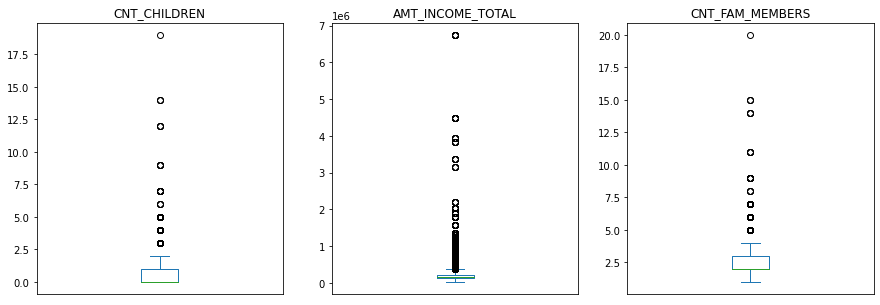

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, c in enumerate(outlier_columns):
    application_df[c].plot(kind='box', ax=axs[i], xticks=[], title=c)
    
plt.show()

In [23]:
application_df[outlier_columns].describe(percentiles=[.001, .01, .1, .5, .75, .90, .95, .99]).T

,count,mean,std,min,0.1%,1%,10%,50%,75%,90%,95%,99%,max
CNT_CHILDREN,438510.0,0.427393,0.724887,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,19.0
AMT_INCOME_TOTAL,438510.0,187520.879910,110080.727479,26100.0,36000.0,54000.0,90000.0,161100.0,225000.0,315000.0,360000.0,540000.0,6750000.0
CNT_FAM_MEMBERS,438510.0,2.194463,0.897210,1.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,5.0,20.0


In [24]:
for c in outlier_columns:
    high = application_df[c].quantile(0.999)
    low = application_df[c].quantile(0.001)
    application_df = application_df[(low < application_df[c]) & (application_df[c] < high)]

In [25]:
credit_df = pd.read_csv("../Data/credit_record.csv")
credit_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [26]:
credit_df['ID'].nunique()

45985

In [27]:
credit_df['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [28]:
credit_df.columns

Index(['ID', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [29]:
credit_df['MONTHS_BALANCE'] = -1*credit_df['MONTHS_BALANCE']

In [30]:
credit_df[['MONTHS_BALANCE']].describe(percentiles=np.arange(0, 1, .1)).T

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
MONTHS_BALANCE,1048575.0,19.136998,14.023498,0.0,0.0,3.0,6.0,9.0,13.0,17.0,21.0,26.0,32.0,40.0,60.0


In [31]:
credit_df.drop(credit_df[credit_df['STATUS'].isin(['C', 'X'])].index, inplace=True)

In [32]:
credit_df['STATUS'] = credit_df['STATUS'].astype('int')

In [33]:
credit_df['STATUS'].value_counts()

0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [34]:
# credit_df['STATUS'] if [0, 1] => Good User(0)
# credit_df['STATUS'] if [2, 3] => Miderate Risky User(1)
# credit_df['STATUS'] if 4 => Risky User(2)
# credit_df['STATUS'] if 5 => High Risky User(3)

In [35]:
def get_risk_status_from_num(status):
    if 0 <= status <= 1:
        return 0
    elif 2 <= status <= 3:
        return 1
    elif status == 4:
        return 2
    elif status == 5:
        return 3

In [36]:
credit_df['STATUS'] = credit_df['STATUS'].apply(get_risk_status_from_num)

In [37]:
credit_df['STATUS'].value_counts()

0    394210
3      1693
1      1188
2       223
Name: STATUS, dtype: int64

In [38]:
agg_credit_df= credit_df.groupby('ID').aggregate(max).reset_index()
agg_credit_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,3,0
1,5001712,18,0
2,5001717,21,0
3,5001718,37,0
4,5001719,42,0
...,...,...,...
40027,5150477,19,0
40028,5150480,49,0
40029,5150482,28,0
40030,5150484,12,0


In [39]:
agg_credit_df['STATUS'].value_counts()

0    39365
1      424
3      195
2       48
Name: STATUS, dtype: int64

In [40]:
merged_df = application_df.merge(agg_credit_df, on='ID', how='inner')
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008838,1,0,1,1,405000.0,0,1,1,1,32.443836,5.523288,0,0,0,10,3.0,38,0
1,5008839,1,0,1,1,405000.0,0,1,1,1,32.443836,5.523288,0,0,0,10,3.0,13,0
2,5008840,1,0,1,1,405000.0,0,1,1,1,32.443836,5.523288,0,0,0,10,3.0,55,0
3,5008841,1,0,1,1,405000.0,0,1,1,1,32.443836,5.523288,0,0,0,10,3.0,3,0
4,5008842,1,0,1,1,405000.0,0,1,1,1,32.443836,5.523288,0,0,0,10,3.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,5142964,1,0,0,1,180000.0,4,4,1,1,29.194521,2.536986,1,1,0,8,3.0,45,1
8316,5142972,1,0,0,1,180000.0,4,4,3,1,29.194521,2.536986,1,1,0,8,3.0,34,1
8317,5143342,1,0,0,1,216000.0,4,4,1,2,35.468493,6.624658,0,0,1,8,3.0,32,3
8318,5145846,0,0,1,1,256500.0,2,1,1,1,48.202740,3.602740,0,1,0,10,3.0,14,1


In [41]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [42]:
X = merged_df[['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']]
y = merged_df['STATUS']

In [43]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

In [44]:
X_resampled, y_resampled = SMOTE().fit_resample(X_scaled, y)

In [45]:
y.value_counts(), y_resampled.value_counts()

(0    8169
 1      94
 3      44
 2      13
 Name: STATUS, dtype: int64,
 0    8169
 1    8169
 3    8169
 2    8169
 Name: STATUS, dtype: int64)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [47]:
clf = RandomForestClassifier().fit(X_train, y_train)

<BarContainer object of 16 artists>

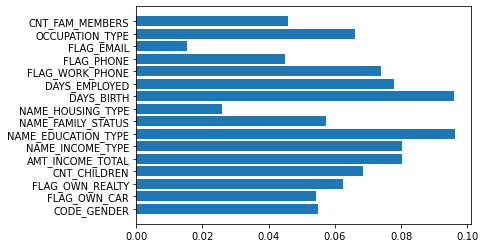

In [48]:
plt.barh(X.columns, clf.feature_importances_)

In [49]:
classifiers = {
    "logistic": LogisticRegression(),
    "svm": SVC(),
    "random_forest": RandomForestClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "k_neighbour": KNeighborsClassifier(),
    "sgd": SGDClassifier(),
    "mlp": MLPClassifier(),
    "ada_boost": AdaBoostClassifier(),
    "xg_boost": XGBClassifier(),
    "gaussian_nb": GaussianNB(),
    "bernouli_nb": BernoulliNB()
}

In [50]:
train_test_results = []

for name, clf in tqdm(classifiers.items()):
    clf.fit(X_train, y_train)
    train_test_results.append({
        "model": name,
        "train_score": clf.score(X_train, y_train),
        "test_score": clf.score(X_test, y_test)
    })

  0%|          | 0/11 [00:00<?, ?it/s]

[21:37:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
train_test_results = pd.DataFrame(train_test_results)
train_test_results.sort_values(['test_score', 'train_score'], ascending=False)

,model,train_score,test_score
8,xg_boost,0.995715,0.988371
2,random_forest,0.996677,0.986127
3,decision_tree,0.996721,0.981230
6,mlp,0.984480,0.979700
4,k_neighbour,0.985354,0.974702
1,svm,0.950553,0.942569
7,ada_boost,0.654483,0.656432
0,logistic,0.603157,0.605223
5,sgd,0.597823,0.595634
10,bernouli_nb,0.499541,0.498929


<AxesSubplot:ylabel='model'>

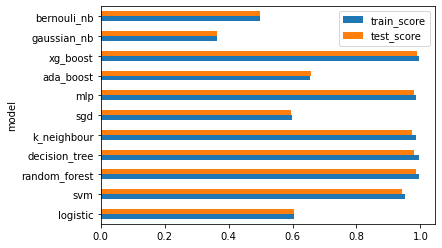

In [52]:
train_test_results.set_index('model').plot(kind='barh')

In [53]:
xgb = XGBClassifier(use_label_encoder=False).fit(X_train, y_train)

[21:38:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 16 artists>

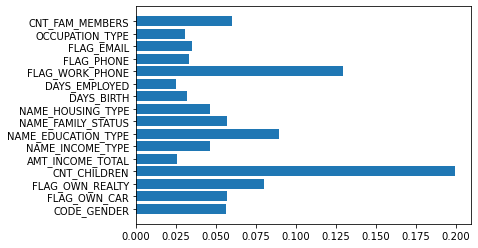

In [54]:
plt.barh(X.columns, xgb.feature_importances_)

In [55]:
y_pred = xgb.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9917    0.9893    0.9905      2429
           1     0.9844    0.9905    0.9875      2424
           2     0.9857    0.9971    0.9914      2425
           3     0.9916    0.9770    0.9842      2525

    accuracy                         0.9884      9803
   macro avg     0.9884    0.9885    0.9884      9803
weighted avg     0.9884    0.9884    0.9884      9803



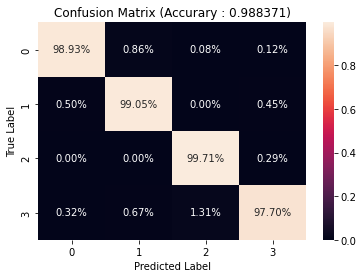

In [57]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, fmt=".2%")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

ax.set_title(f"Confusion Matrix (Accurary : {accuracy_score(y_test, y_pred):.6f})")

plt.show()

In [58]:
joblib.dump(xgb, "../Data/credit_card_approval_prediction.pkl")

['../Data/credit_card_approval_prediction.pkl']